In [ ]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")

In [ ]:
movie = pd.read_csv('movie_preprocessing5.csv',encoding='utf-8')
# movie=movie1[:5000]

In [ ]:
movie.shape

(32462, 10)

In [ ]:
movie.columns

Index(['Title', 'Score', 'Review count', 'Genre', 'Original Language',
       'Runtime', 'Rating', 'Director', 'Cast', 'Synopsis'],
      dtype='object')

## Weight Rating


### 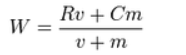

- W: weight rating
- R: average score for the movie
- v: number of review_count for the movie
- m: minimum review_count required to be listed
- C: the mean score across the whole dataset

In [ ]:
C = movie['Score'].mean()
m =  movie['Review count'].quantile(0.9)
# movie_list = movie.copy().loc[movie['Review count']>=m]

In [ ]:
# Defining a function
def weighted_rating(x,m=m,C=C):
    v=x['Review count']
    R=x['Score']
    return ((R*v+C*m)/(v+m))

In [ ]:
# movie_list['WR_score']=movie_list.apply(weighted_rating,axis=1)
# movie_list.head()

# Sort the movies based on their WR_score
# movie_list = movie_list.sort_values('WR_score',ascending=False)
# movie_list.head(10)

## Cosine Similarity

In [ ]:
movie['General'] = movie['Genre'] + ' '  + movie['Original Language']+ ' ' + movie['Rating']+' '+ movie['Director'] + ' ' + movie['Cast']+' ' + movie['Synopsis']

In [ ]:
for i in movie['General'][:10]:
  print(i)

Drama Hindi PG-13 R. Balki Amitabh Bachchan, Abhishek Bachchan, Vidya Balan, Paresh Rawal, R. Balki, R. Balki, Sunil Manchanda A politician's 13-year-old son has a rare disorder that makes him appear to be a grown man.
Drama, Comedy English PG-13 Niels Mueller David Sullivan, Bill Heck, Kristen Johnston, Tanya Fischer, Cooper J. Friedman, Braden Andersen, Andi Matusiak, Mark Borchardt, Kendall Dakof, Leah Joy Gayle, Braden Anderson, Niels Mueller, Jason Naczek, Scott K. Foley, Hongtao Liu, Niels Mueller, Josh Rosenberg, Alexander Payne, Jinhua Yang, Nathaniel Goodman, Tracy Adams, Nicholas Jacobson-Larson, Kelly Fallon, Ania Bista, Kate M. Blomquist, Nicole Abellera After losing a custody battle, perpetual teenager Wayne Stobierski steals his son away for one last father-son weekend to the city of their dreams -- Milwaukee, Wisconsin. What's supposed to be a light-hearted adventure, transforms into a journey of profound redemption.
Comedy, Adventure Swedish R Felix Herngren Robert Gust

### Preprocessing

In [ ]:
# # Preprocessing Review column
# import pandas as pd
# from nltk.corpus import stopwords
# # from textblob import TextBlob
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import spacy
# nlp = spacy.load("en_core_web_sm")
# stop_words = set(stopwords.words('english'))
# import re

# def clean_review(text):
#     text = text.lower()
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = text.strip()
#     text = text.replace('\n', ' ')
#     text = re.sub(r'[^\w\s]', '', text)
#     #tokenizing
    
#     # lemmatization
#     doc = nlp(text)
#     text = " ".join([token.lemma_ for token in doc])
#     return text

In [ ]:
tfidf= TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie['General'])
tfidf_matrix.shape

(32462, 143425)

In [ ]:
# # Import CountVectorizer and create the count matrix
# from sklearn.feature_extraction.text import CountVectorizer

# count = CountVectorizer(stop_words='english')
# # count_matrix = count.fit_transform(movie['General'])
# # count_matrix.shape
# tfidf_matrix = count.fit_transform(movie['General'])
# # tfidf_matrix.shape

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Reduce the dimensions of the TF-IDF matrix using SVD
svd = TruncatedSVD(n_components=100)
svd_matrix = svd.fit_transform(tfidf_matrix)
# Calculate cosine similarity on the reduced matrix
cosine_sim = cosine_similarity(svd_matrix, svd_matrix)


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.metrics.pairwise import cosine_similarity

# # Reduce the dimensions of the TF-IDF matrix using PCA
# pca = PCA(n_components=100)
# pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# # Calculate cosine similarity on the reduced matrix
# cosine_sim = cosine_similarity(pca_matrix, pca_matrix)


## Recommend Movies

In [ ]:
movie = movie.reset_index()
indices = pd.Series(movie.index, index=movie['Title'])

In [ ]:
indices

Title
Paa                                                                    0
Small Town Wisconsin                                                   1
The 100-Year-Old Man Who Climbed Out the Window and Disappeared        2
Escape From Alcatraz                                                   3
Adrift                                                                 4
                                                                   ...  
Chromophobia                                                       32457
American Gun                                                       32458
Tchoupitoulas                                                      32459
Bag It                                                             32460
Northeast                                                          32461
Length: 32462, dtype: int64

In [ ]:
def get_recommendations(title, consine_sim=cosine_sim):
    #index of the movie that matches the title
    idx = indices[title]

    #pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    #Sorting the movies based on the similarity scores
    sim_scores = sorted(sim_scores,key = lambda x: x[1],reverse=True)

    #Scores of 10 most similar movies
    sim_scores = sim_scores[1:30]

    #Get the movie index
    movie_indicates = [i[0] for i in sim_scores]

    #Combine Cosine similarity and weight score
    movie_pred = movie.iloc[movie_indicates][['Title', 'Genre','Score','Review count','Original Language']]
    C = movie['Review count'].mean()
    m = movie['Review count'].quantile(0.40)
    t = movie['Score'].quantile(0.5)
    qualified = movie_pred[(movie_pred['Review count'] >= m) & (movie_pred['Score'] >= t)]
    qualified['WR_score'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('WR_score', ascending=False).head(15)
    return qualified
    

In [ ]:
get_recommendations('Hospitality')

,Title,Genre,Score,Review count,Original Language,WR_score
10639,Cold in July,"Drama, Mystery & thriller",75.5,10117,English,67.607487
29180,Aileen: Life and Death of a Serial Killer,Documentary,79.0,5061,English (United Kingdom),66.874674
24459,Aileen Wuornos: The Selling of a Serial Killer,Documentary,83.0,1008,English,65.154747
12549,Tales of the Grim Sleeper,Documentary,88.5,539,English,64.944929
21238,Cannery Row,Drama,73.0,508,English,64.610512
17106,Whitney: Can I Be Me,"Documentary, Music",74.5,327,English,64.570274
